In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 한글 폰트 설정 (Mac의 경우)
mpl.rc('font', family='AppleGothic')
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

📊 LSTM (log+lag) 예측 성능
RMSE: 270.53
MAE : 269.48
R2  : 0.3176


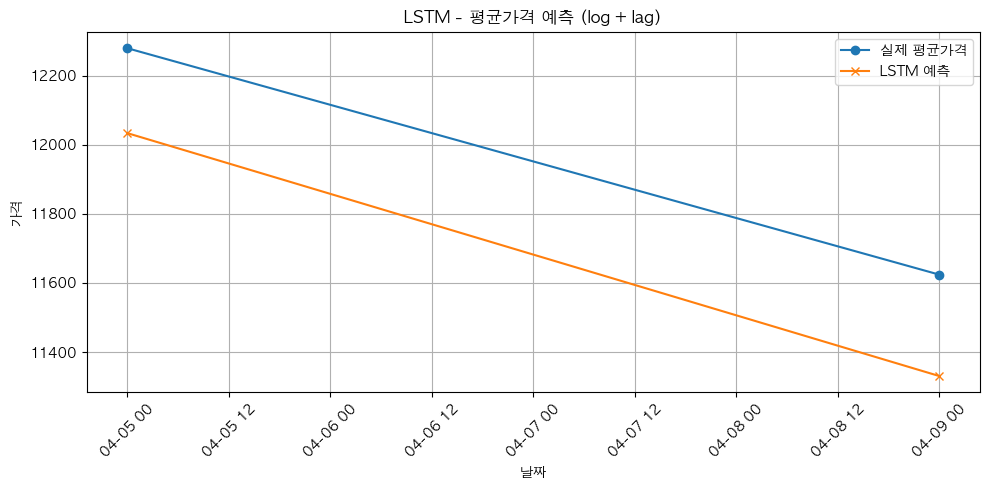

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 및 전처리
df = pd.read_csv("cabbage_data/cabbage_final.csv", parse_dates=["DATE"])
df = df.sort_values("DATE")

# 필요없는 열 제거 및 lag 추가
df.drop(columns=["전일대비_반입량차이", "전일대비_반입량변화율(%)", "insolation", "wind", "공휴일여부"], inplace=True)
df["lag1"] = df["평균가격"].shift(1)
df["lag7"] = df["평균가격"].shift(7)
df["log_평균가격"] = np.log1p(df["평균가격"])
df["log_lag1"] = np.log1p(df["lag1"])
df["log_lag7"] = np.log1p(df["lag7"])

# 사용할 피처 및 타겟
feature_cols = [
    "humidity", "precipitation", "temperature", "총반입량",
    "전일대비_가격차이", "전일대비_가격변화율(%)", "일요일여부",
    "log_lag1", "log_lag7"
]
target_col = "log_평균가격"

# 날짜 기준 분리
target_start = pd.to_datetime("2025-03-10")
target_end = pd.to_datetime("2025-04-09")
df = df.dropna(subset=[target_col] + feature_cols)

# 시계열 입력 형성 (lookback: 7일)
lookback = 7
def create_sequences(data, target, lookback=7):
    Xs, ys = [], []
    for i in range(lookback, len(data)):
        Xs.append(data[i-lookback:i])
        ys.append(target[i])
    return np.array(Xs), np.array(ys)

# train/test 분리
train_df = df[df["DATE"] < target_start]
test_df = df[(df["DATE"] >= target_start) & (df["DATE"] <= target_end)]

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df[feature_cols])
X_test_scaled = scaler.transform(test_df[feature_cols])

# 시퀀스 생성
X_train_seq, y_train_seq = create_sequences(X_train_scaled, train_df[target_col].values, lookback)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, test_df[target_col].values, lookback)

# Dataset 정의
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_dataset = SeqDataset(X_train_seq, y_train_seq)
test_dataset = SeqDataset(X_test_seq, y_test_seq)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1])
        return out.squeeze()

model = LSTMModel(input_size=X_train_seq.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습
for epoch in range(100):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

# 예측
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
    y_pred_log = model(X_test_tensor).numpy()
    y_pred = np.expm1(y_pred_log)  # 복원
    y_true = np.expm1(y_test_seq)

# 평가
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("📊 LSTM (log+lag) 예측 성능")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R2  : {r2:.4f}")

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(test_df["DATE"].iloc[lookback:], y_true, label="실제 평균가격", marker='o')
plt.plot(test_df["DATE"].iloc[lookback:], y_pred, label="LSTM 예측", marker='x')
plt.title("LSTM - 평균가격 예측 (log + lag)")
plt.xlabel("날짜")
plt.ylabel("가격")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
